In [1]:
''' Jupyter Notebook for results processing and plotting '''

import os
import pickle as pkl
from glob import glob
import numpy as np
import re

In [2]:
with open('new_hyps/saves_LR_D0.0001_LR_G0.0002_WGAN_4242_64/cifar10/WGAN/WGAN_history_25.pkl', 'rb') as f:
    data = pkl.load(f)

In [3]:
print(data.keys())

data['total_time'][0]/60

dict_keys(['LR_D', 'LR_G', 'D_loss', 'G_loss', 'per_epoch_time', 'total_time', 'FIDs', 'FID_time'])


52.05373058319092

In [ ]:
def find_logs(path='newest_hyper', amt_epochs=25):
    '''
        Recursively searches folders for log files with corresponding amount of epochs in the name of a file
        
        Args:
        
        :path: path to file folders
        :amt_epochs: amount of epochs experiment was trained on
        
        Returns:
        
        :le_wgan, le_gan: two lists containing file paths to WGAN and DCGAN experiments with the same amt of epochs
            
    '''
    le_wgan, le_gan = [], []
    for f in sorted(glob(os.path.join(path, '**/*.*'), recursive=True)):
        if os.path.basename(f) == f'WGAN_history_{amt_epochs}.pkl':
            le_wgan.append(f)
        elif os.path.basename(f) == f'GAN_history_{amt_epochs}.pkl':
            le_gan.append(f)
    return le_wgan, le_gan

find_logs(amt_epochs=25)[1]

In [ ]:
def search_statements(i, ct):
    p = dict()
    pat = re.search(r'(LR_[G])(\w+[.|-]\d+)', i)
    pat2 = re.search(r'(LR_[D])(\w+[.|-]\d+)', i)
    pat3 = re.search(r'_(\d{4})', i)
    pat4 = re.search(r'\\(WGAN|GAN)\\', i)
    p[f'experiment'] = ct
    p['LR_D'] = float(pat2.group(2))
    p['LR_G'] = float(pat.group(2))
    p['SEED'] = int(pat3.group(1))
    p['gan_type'] = pat4.group(1)
    return p

def create_dict(list_of_paths, bsize=None):
    '''
        Creates dictionary of information kept in the pickle file
        
        Args:
        
        :list_of_paths: list of paths to the log files
        :bsize: selected batch-size for training
        
        Returns:
        
        :dicts: list of dictionaries, one per file
        
    '''
    counter = 0
    dicts = []
    
    for e,i in enumerate(list_of_paths):
        
        p = search_statements(i, counter)
        
        try:
            pat5 = re.search(fr'({bsize})', i)
            p['BATCH_SIZE'] = int(pat5.group(1))
        except AttributeError:
            p['BATCH_SIZE'] = 64
            
        counter += 1
        dicts.append(p)
        
        with open(i, 'rb') as f:
            data = pkl.load(f)
            dicts[e]['FIDs'] = data['FIDs']
            men = np.mean(dicts[e]['FIDs'])
            dicts[e]['Mean_FID'] = men
        
    return dicts

create_dict(find_logs()[1], 128)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


def aggregate(data, mode='mean'):
    '''
    
        Takes dictionary with data as argument, separates data by learning rate, stacks experiments into form (epochs, experiment_iter)
        and takes mean and std over (experiment_iter) dimension.
        
        Args:
            :data: dictionary with data
        
        Returns:
            :dd: defaultdict with separated and aggregated data
        
    '''
    
    dd = defaultdict(list)
    for i in data:
        lr_d, lr_g = i['LR_D'], i['LR_G']
        dd[lr_d, lr_g].append(i['FIDs'])
        

    ks = [i for i in dd.keys()]
    
    if mode == 'mean':
        
        for i in ks:
            dd[i] = np.mean(np.stack(dd[i], axis=1), axis=1)
        return dd
    
    if mode == 'std':
        
        for i in ks:
            dd[i] = np.sqrt(np.var(np.stack(dd[i], axis=1), axis=1))
        return dd
    
    else:
        
        return dd
    

def separate(data, lr_d, lr_g, bsize):
    '''
        Separates data with specific learning rates.
        
    '''
    
    
    new_data = []
    for i in data:
        
        if i['LR_D'] == lr_d and i['LR_G'] == lr_g and i['BATCH_SIZE'] == bsize:
            new_data.append(i)
                
    means, stds = aggregate(new_data, 'mean')[lr_d, lr_g], aggregate(new_data, 'std')[lr_d, lr_g]
    return (new_data, means, stds)
            


def create_line_plot(data, means, stds):
    '''
        Creates line plot for input data.
    
    '''
    fig, ax = plt.subplots(figsize=(13,9))
    for dat in data:

        bsize = dat['BATCH_SIZE'] 
        eps = [i for i in range(1, len(dat['FIDs'])+1)]
        ax.plot(eps, dat['FIDs'], label=f"{dat['gan_type']}_{dat['LR_D']}_{dat['LR_G']}_{dat['SEED']}", alpha=0.22)
        ax.set_title(f"{dat['gan_type']} trained for {len(eps)} epochs with batch size {bsize}")
        
    ax.legend()
    sns.lineplot(x=eps, y=means, label=f"mean_line", alpha=1).lines[-1].set_linestyle('--')
    lower_bound = means - stds
    upper_bound = means + stds
    ax.fill_between(eps, lower_bound, upper_bound, alpha=0.6, interpolate=True)
    ax.set(xlabel='Epochs', ylabel='FID')
    
#create_line_plot(dat[0])


In [7]:
# find logs in the directory with saves, extract them into dictionary
example_dat = create_dict(find_logs('newest_hyper', 25)[1], 128)
# to make a plot, separate out data by choosing learning rates and batch_size
example_sep, example_mean, example_std = separate(example_dat, 0.0003, 0.0002, 64)

for d in example_dat:
    if len(d['FIDs']) < 25:
        print(f"LR_D {d['LR_D']} LR_G {d['LR_G']} SEED {d['SEED']} LEN_EPOCHS {len(d['FIDs'])} BATCH_SIZE {d['BATCH_SIZE']} GAN_TYPE {d['gan_type']}")

In [8]:
# find logs in the directory with saves, extract them into dictionary
example_dat = create_dict(find_logs('newest_hyper', 25)[0], 128)
# to make a plot, separate out data by choosing learning rates and batch_size
example_sep, example_mean, example_std = separate(example_dat, 0.0003, 0.0002, 64)

for d in example_dat:
    if len(d['FIDs']) < 25:
        print(f"LR_D {d['LR_D']} LR_G {d['LR_G']} SEED {d['SEED']} LEN_EPOCHS {len(d['FIDs'])} BATCH_SIZE {d['BATCH_SIZE']} GAN_TYPE {d['gan_type']}")

In [7]:
def create_line_plot(data, means, stds, ax):
    '''
        Creates line plot for input data. Modified version of previous function, creates as many subplots as specified by user.
    
    '''
    #fig, ax = plt.subplots(figsize=(13,9))
    
    
    if ax != None:
        plt.sca(ax)
    
    props = []
    for dat in data:
        bsize = dat['BATCH_SIZE'] 
        eps = [i for i in range(1, len(dat['FIDs'])+1)]
        plt.plot(eps, dat['FIDs'], label=f"seed {dat['SEED']}", alpha=0.6)
        plt.plot(np.argmin(means)+1, means[np.argmin(means)], 'ro')
        plt.title(f"LR_D: {dat['LR_D']}, LR_G: {dat['LR_G']}", fontsize=14)
        props = [dat['gan_type'], len(eps), bsize]
        
    #plt.legend(fontsize='large')
    plt.plot(eps, means, '--', label=r'mean_line', alpha=1)
    lower_bound = means - stds
    upper_bound = means + stds
    plt.fill_between(eps, lower_bound, upper_bound, alpha=0.3, interpolate=True)
    

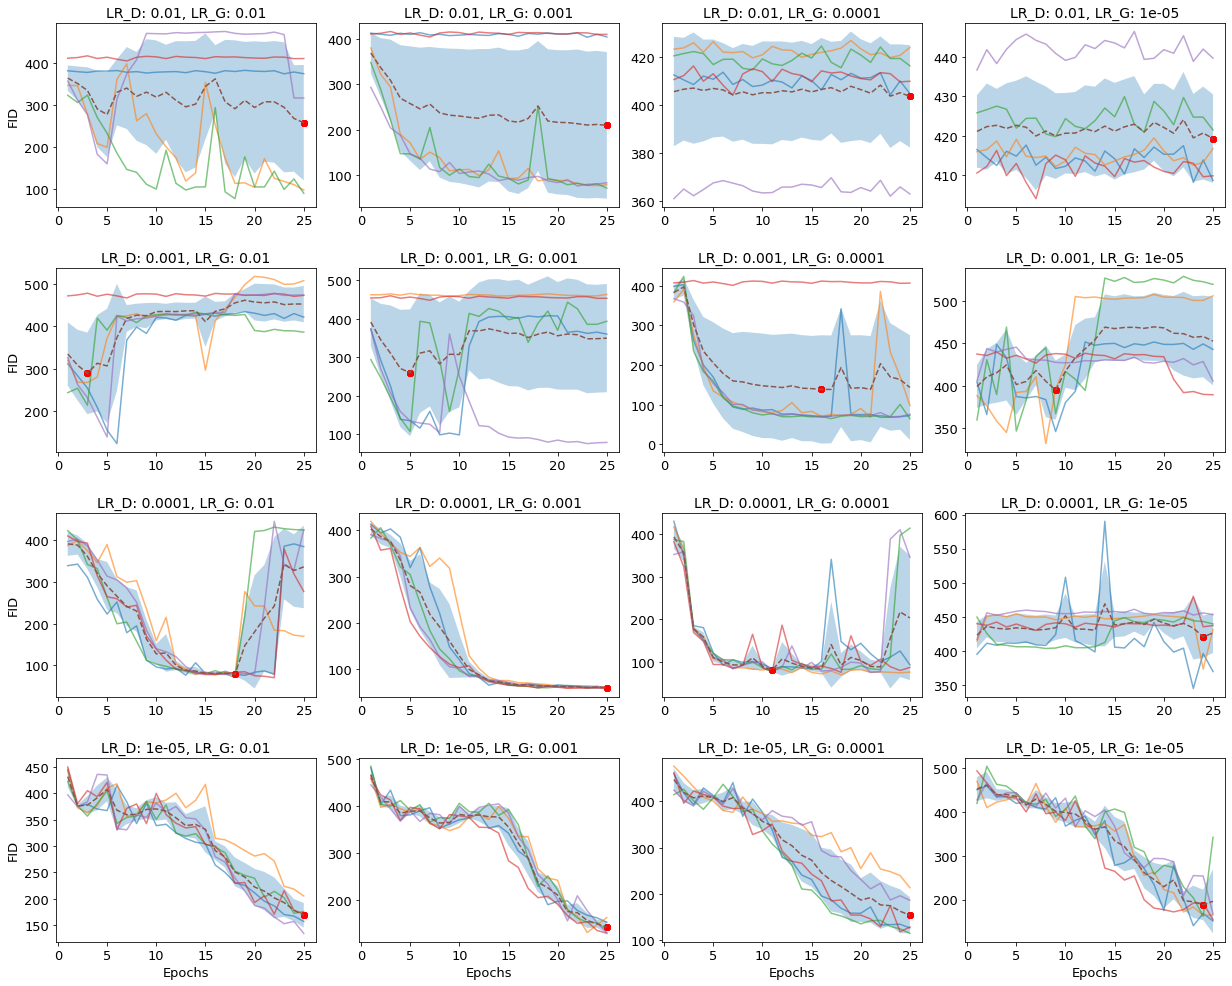

In [24]:
# create plot for 2nd group of hyperparams for GAN, bs=64
import matplotlib
matplotlib.rcParams.update({'font.size': 13})

lr_list = [(0.01, 0.01), (0.01, 0.001), (0.01, 0.0001), (0.01, 1e-5),
           (0.001, 0.01), (0.001, 0.001), (0.001, 0.0001), (0.001, 1e-5),
           (0.0001, 0.01), (0.0001, 0.001), (0.0001, 0.0001), (0.0001, 1e-5),
           (1e-5, 0.01), (1e-5, 0.001), (1e-5, 0.0001), (1e-5, 1e-5)]
b_sizes = [64]

fig, ax = plt.subplots(figsize=(17,11), nrows=4, ncols=4)
ax = ax.flatten()
dat_gan = create_dict(find_logs('newest_hyper')[1], 128)

# for i in dat_gan:
#     print(f" gan_type: {i['gan_type']} LR_D: {i['LR_D']} LR_G: {i['LR_G']} SEED: {i['SEED']} b_size: {i['BATCH_SIZE']} FID_shape: {1 if len(i['FIDs']) == 25 else 0}")

for b_size in b_sizes:
    for e,lr in enumerate(lr_list):
        data, means, stds = separate(dat_gan, lr[0], lr[1], b_size)
        p = create_line_plot(data, means, stds, ax=ax[e])
        eps = [i for i in range(1, len(data[0]['FIDs'])+1)]

#ax[0].legend(fontsize='medium')

#fig.suptitle(f"{dat_gan[0]['gan_type']} trained for {len(eps)} epochs with batch size {b_sizes[0]}", fontsize = 17)
fig.tight_layout(pad=0.9)
fig.subplots_adjust(top=1.2)
plt.setp(ax[[12,13,14,15]], xlabel='Epochs')
plt.setp(ax[[0,4,8,12]], ylabel='FID')

plt.savefig(f'plots/gan_hyperset_{b_sizes[0]}.jpg', bbox_inches='tight')
    

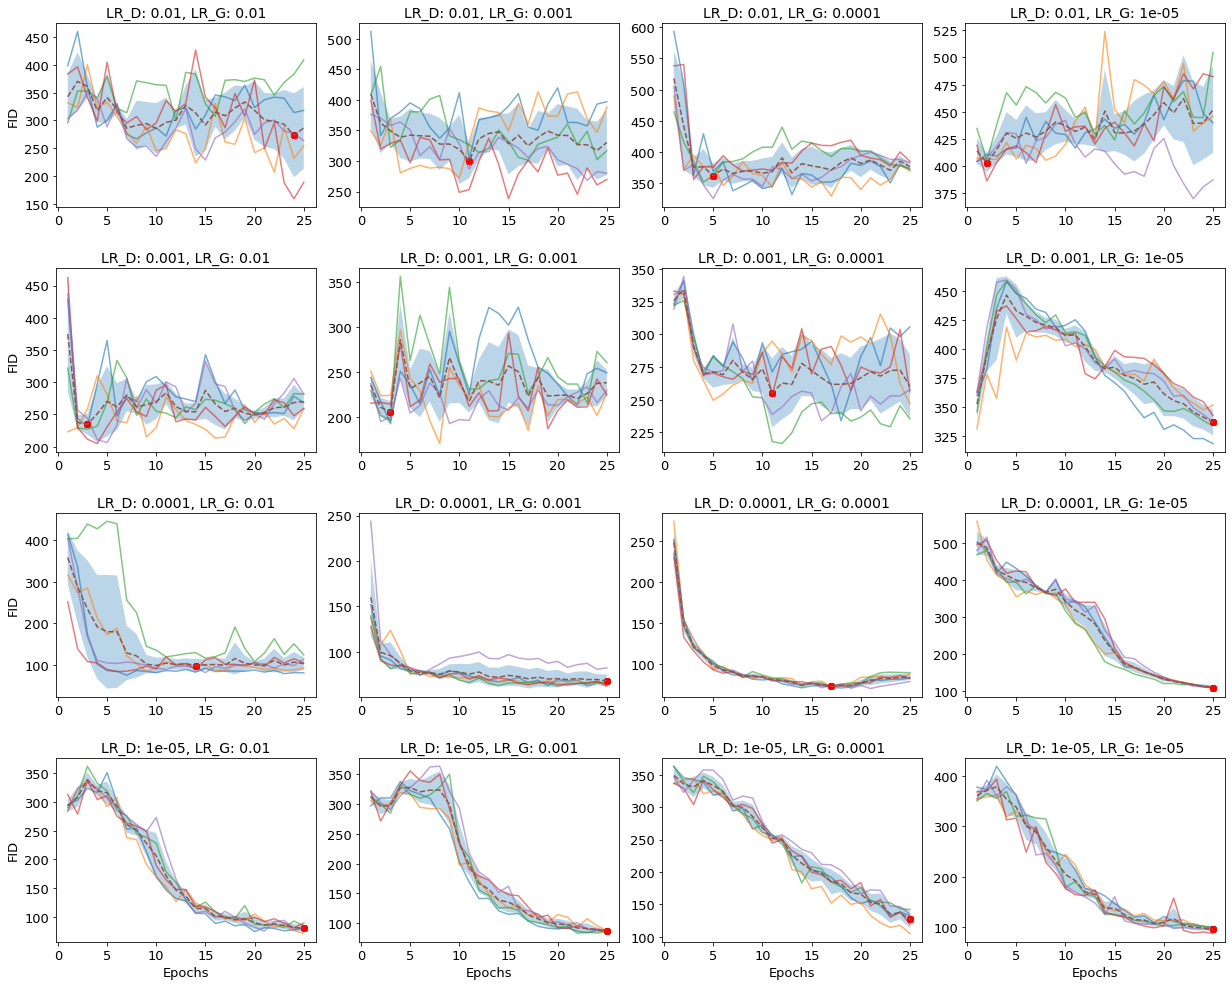

In [25]:
# create plot for 2nd group of hyperparams for WGAN, bs=64
import matplotlib
matplotlib.rcParams.update({'font.size': 13})

lr_list = [(0.01, 0.01), (0.01, 0.001), (0.01, 0.0001), (0.01, 1e-5),
           (0.001, 0.01), (0.001, 0.001), (0.001, 0.0001), (0.001, 1e-5),
           (0.0001, 0.01), (0.0001, 0.001), (0.0001, 0.0001), (0.0001, 1e-5),
           (1e-5, 0.01), (1e-5, 0.001), (1e-5, 0.0001), (1e-5, 1e-5)]
b_sizes = [64]

fig, ax = plt.subplots(figsize=(17,11), nrows=4, ncols=4)
ax = ax.flatten()
dat_gan = create_dict(find_logs('newest_hyper')[0], 128)

# for i in dat_gan:
#     print(f" gan_type: {i['gan_type']} LR_D: {i['LR_D']} LR_G: {i['LR_G']} SEED: {i['SEED']} b_size: {i['BATCH_SIZE']} FID_shape: {1 if len(i['FIDs']) == 25 else 0}")

for b_size in b_sizes:
    for e,lr in enumerate(lr_list):
        data, means, stds = separate(dat_gan, lr[0], lr[1], b_size)
        p = create_line_plot(data, means, stds, ax=ax[e])
        eps = [i for i in range(1, len(data[0]['FIDs'])+1)]

#ax[0].legend(fontsize='medium')

#fig.suptitle(f"{dat_gan[0]['gan_type']} trained for {len(eps)} epochs with batch size {b_sizes[0]}", fontsize = 17)
fig.tight_layout(pad=0.9)
fig.subplots_adjust(top=1.2)
plt.setp(ax[[12,13,14,15]], xlabel='Epochs')
plt.setp(ax[[0,4,8,12]], ylabel='FID')

plt.savefig(f'plots/wgan_hyperset_{b_sizes[0]}.jpg', bbox_inches='tight')

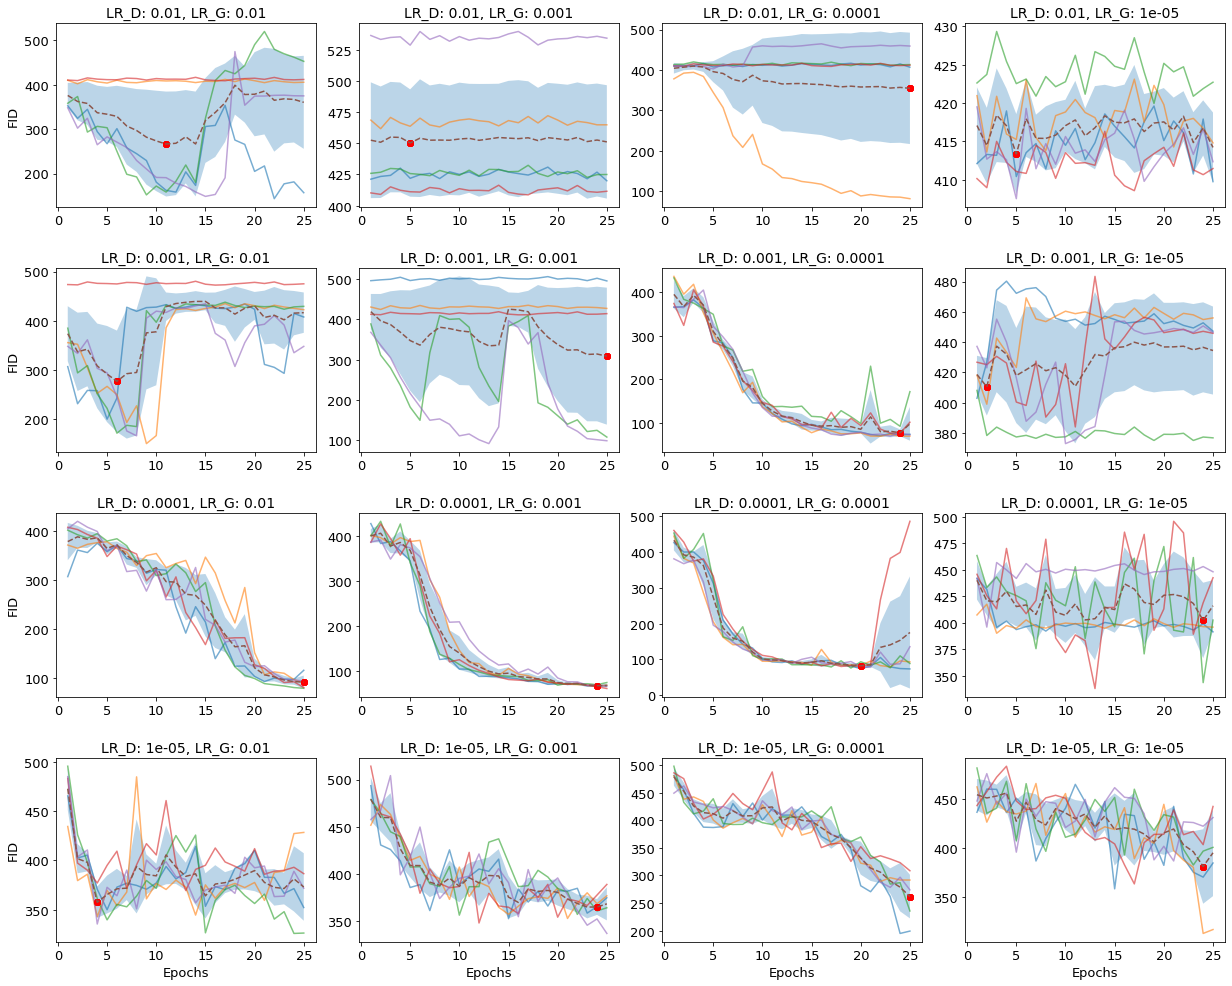

In [26]:
# create plot for 2nd group of hyperparams for GAN, bs=128
import matplotlib
matplotlib.rcParams.update({'font.size': 13})

lr_list = [(0.01, 0.01), (0.01, 0.001), (0.01, 0.0001), (0.01, 1e-5),
           (0.001, 0.01), (0.001, 0.001), (0.001, 0.0001), (0.001, 1e-5),
           (0.0001, 0.01), (0.0001, 0.001), (0.0001, 0.0001), (0.0001, 1e-5),
           (1e-5, 0.01), (1e-5, 0.001), (1e-5, 0.0001), (1e-5, 1e-5)]
b_sizes = [128]

fig, ax = plt.subplots(figsize=(17,11), nrows=4, ncols=4)
ax = ax.flatten()
dat_gan = create_dict(find_logs('newest_hyper')[1], 128)

# for i in dat_gan:
#     print(f" gan_type: {i['gan_type']} LR_D: {i['LR_D']} LR_G: {i['LR_G']} SEED: {i['SEED']} b_size: {i['BATCH_SIZE']} FID_shape: {1 if len(i['FIDs']) == 25 else 0}")

for b_size in b_sizes:
    for e,lr in enumerate(lr_list):
        data, means, stds = separate(dat_gan, lr[0], lr[1], b_size)
        p = create_line_plot(data, means, stds, ax=ax[e])
        eps = [i for i in range(1, len(data[0]['FIDs'])+1)]

#ax[0].legend(fontsize='medium')

#fig.suptitle(f"{dat_gan[0]['gan_type']} trained for {len(eps)} epochs with batch size {b_sizes[0]}", fontsize = 17)
fig.tight_layout(pad=0.9)
fig.subplots_adjust(top=1.2)
plt.setp(ax[[12,13,14,15]], xlabel='Epochs')
plt.setp(ax[[0,4,8,12]], ylabel='FID')

plt.savefig(f'plots/gan_hyperset_{b_sizes[0]}.jpg', bbox_inches='tight')

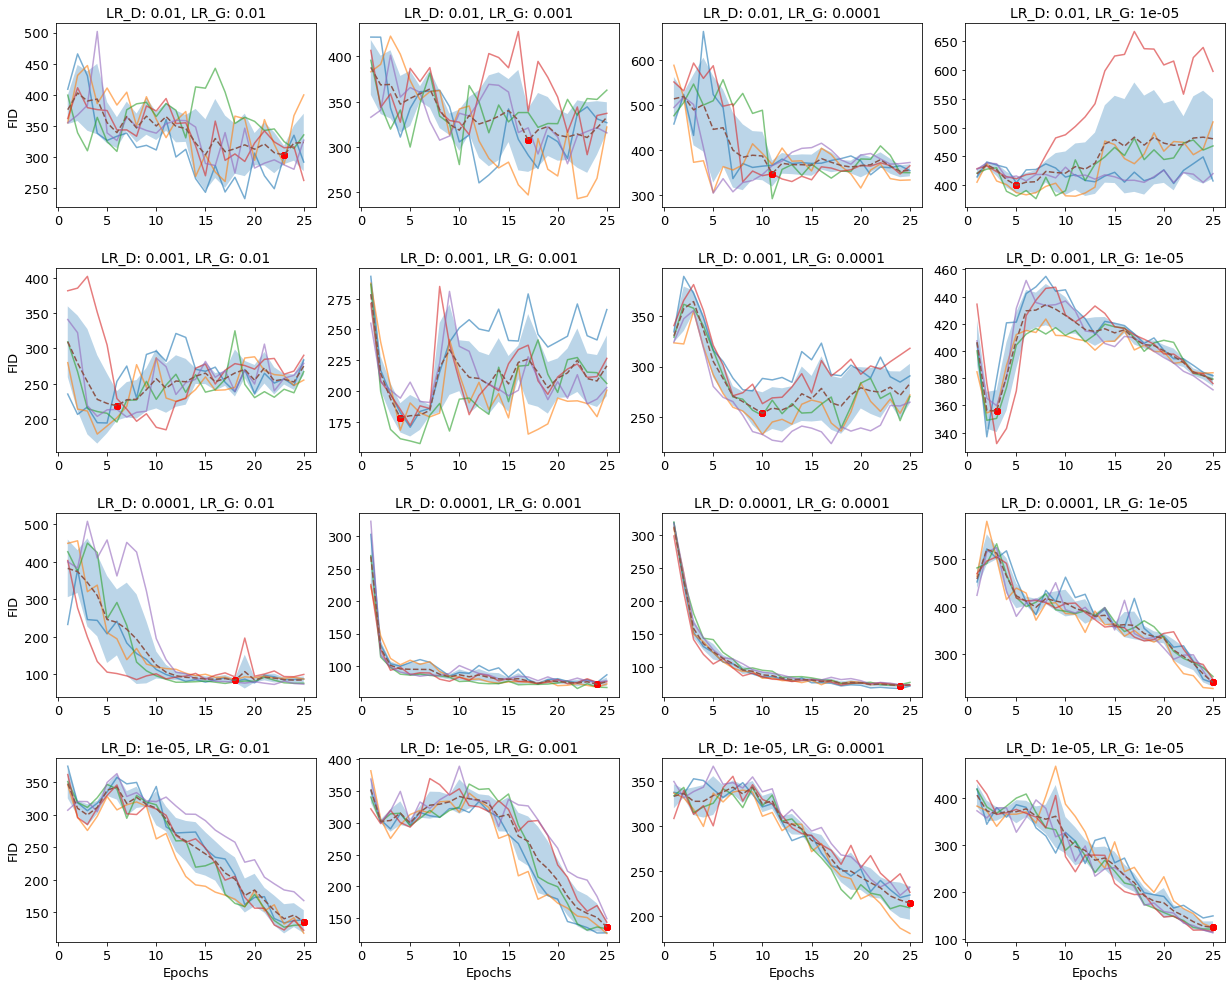

In [27]:
# create plot for 2nd group of hyperparams for WGAN, bs=128
import matplotlib
matplotlib.rcParams.update({'font.size': 13})

lr_list = [(0.01, 0.01), (0.01, 0.001), (0.01, 0.0001), (0.01, 1e-5),
           (0.001, 0.01), (0.001, 0.001), (0.001, 0.0001), (0.001, 1e-5),
           (0.0001, 0.01), (0.0001, 0.001), (0.0001, 0.0001), (0.0001, 1e-5),
           (1e-5, 0.01), (1e-5, 0.001), (1e-5, 0.0001), (1e-5, 1e-5)]
b_sizes = [128]

fig, ax = plt.subplots(figsize=(17,11), nrows=4, ncols=4)
ax = ax.flatten()
dat_gan = create_dict(find_logs('newest_hyper')[0], 128)

# for i in dat_gan:
#     print(f" gan_type: {i['gan_type']} LR_D: {i['LR_D']} LR_G: {i['LR_G']} SEED: {i['SEED']} b_size: {i['BATCH_SIZE']} FID_shape: {1 if len(i['FIDs']) == 25 else 0}")

for b_size in b_sizes:
    for e,lr in enumerate(lr_list):
        data, means, stds = separate(dat_gan, lr[0], lr[1], b_size)
        p = create_line_plot(data, means, stds, ax=ax[e])
        eps = [i for i in range(1, len(data[0]['FIDs'])+1)]

#ax[0].legend(fontsize='medium')

#fig.suptitle(f"{dat_gan[0]['gan_type']} trained for {len(eps)} epochs with batch size {b_sizes[0]}", fontsize = 17)
fig.tight_layout(pad=0.9)
fig.subplots_adjust(top=1.2)
plt.setp(ax[[12,13,14,15]], xlabel='Epochs')
plt.setp(ax[[0,4,8,12]], ylabel='FID')

plt.savefig(f'plots/wgan_hyperset_{b_sizes[0]}.jpg', bbox_inches='tight')

In [16]:
import pandas as pd

lr_list = [(0.01, 0.01), (0.01, 0.001), (0.01, 0.0001), (0.01, 1e-5),
           (0.001, 0.01), (0.001, 0.001), (0.001, 0.0001), (0.001, 1e-5),
           (0.0001, 0.01), (0.0001, 0.001), (0.0001, 0.0001), (0.0001, 1e-5),
           (1e-5, 0.01), (1e-5, 0.001), (1e-5, 0.0001), (1e-5, 1e-5)]
b_sizes = [128]

res = pd.DataFrame()
data = create_dict(find_logs('newest_hyper')[1], 128)
fids_gan_128 = []
fids_gan_128_best = []

for b_size in b_sizes:
    for e,lr in enumerate(lr_list):
        last_fids = []
        best_fids = []
        dat, means, stds = separate(data, lr[0], lr[1], b_size)
        last_fid, lr_d, lr_g, bsize, gan_type = means[-1], dat[0]['LR_D'], dat[0]['LR_G'], dat[0]['BATCH_SIZE'], dat[0]['gan_type']
        print(means)
        print(np.argmin(means)+1)
        #fids_gan_128_best.append((round(means[np.argmin(means)], 2), round(stds[np.argmin(means)], 2)))
        for i in dat:
            last_fids.append((i['FIDs'][-1]))
            best_fids.append(i['FIDs'][np.argmin(means)])
        print(last_fids)
        res = res.append({'LR_D and LR_G' : (lr_d, lr_g), 'Mean FID from last epoch across all runs' : f'{round(last_fid, 2)} \u00B1 {round(stds[-1], 2)}', 'Batch Size' : str(bsize), 'GAN Type': gan_type, 'Best mean FID achieved': f'{round(np.mean(best_fids), 2)} \u00B1 {round(stds[np.argmin(means)], 2)}'}, ignore_index=True)
        fids_gan_128_best.append(best_fids)
        fids_gan_128.append(last_fids)

res = res[ [ col for col in res.columns if col != 'Best mean FID achieved' ] + ['Best mean FID achieved'] ]
print(fids_gan_128)
print(fids_gan_128_best)
res.to_excel('results_gan_128.xlsx')
res

[375.57885886 362.01000084 357.56886913 336.71234593 333.39062748
 328.47598225 306.83070703 296.80745787 281.75906934 273.31766972
 266.29574435 268.04468027 282.68692602 266.51782219 319.3291951
 337.27958189 359.13990306 398.58628071 377.63768328 378.30404658
 385.36029534 364.72059035 367.99004435 366.5999284  360.06885167]
11
[156.89564438805627, 405.22751914038537, 452.17835403389864, 411.45647997873823, 374.58626079782255]
[452.36027407 450.74731425 454.84541344 454.59343319 450.12413339
 454.01054707 452.38667053 452.49182716 452.34267811 453.31979322
 453.86823326 452.28919292 453.34854517 454.52746272 454.04567444
 453.60882874 454.31184679 452.08282905 454.40378368 453.55122345
 452.56229376 454.54263312 451.27541917 452.50681985 451.01127367]
5
[419.86485065591626, 464.7067002351786, 424.9040462072655, 411.45647997873823, 534.1242912913774]
[404.01575943 406.72876437 409.51170204 407.11410282 395.55241787
 391.08161079 376.24286559 370.79853511 386.58827197 372.90250745
 37

,Batch Size,GAN Type,LR_D and LR_G,Mean FID from last epoch across all runs,Best mean FID achieved
0,128,GAN,"(0.01, 0.01)",360.07 ± 104.55,266.3 ± 117.98
1,128,GAN,"(0.01, 0.001)",451.01 ± 45.41,450.12 ± 43.01
2,128,GAN,"(0.01, 0.0001)",354.2 ± 138.03,354.2 ± 138.03
3,128,GAN,"(0.01, 1e-05)",414.21 ± 4.55,413.36 ± 5.2
4,128,GAN,"(0.001, 0.01)",416.48 ± 41.0,277.02 ± 103.04
5,128,GAN,"(0.001, 0.001)",308.53 ± 169.63,308.53 ± 169.63
6,128,GAN,"(0.001, 0.0001)",97.8 ± 38.68,77.26 ± 7.91
7,128,GAN,"(0.001, 1e-05)",434.46 ± 29.04,410.5 ± 18.97
8,128,GAN,"(0.0001, 0.01)",90.92 ± 13.25,90.92 ± 13.25
9,128,GAN,"(0.0001, 0.001)",66.76 ± 4.31,66.42 ± 1.6


In [15]:
lr_list = [(0.01, 0.01), (0.01, 0.001), (0.01, 0.0001), (0.01, 1e-5),
           (0.001, 0.01), (0.001, 0.001), (0.001, 0.0001), (0.001, 1e-5),
           (0.0001, 0.01), (0.0001, 0.001), (0.0001, 0.0001), (0.0001, 1e-5),
           (1e-5, 0.01), (1e-5, 0.001), (1e-5, 0.0001), (1e-5, 1e-5)]
b_sizes = [64]

# [(0.0001, 5e-05), (0.0002, 5e-05), (0.0004, 0.0001), (0.0004, 0.0002)]
res = pd.DataFrame()
data = create_dict(find_logs('newest_hyper')[0], 128)
fids_wgan_64 = []
fids_wgan_64_best = []

for b_size in b_sizes:
    for e,lr in enumerate(lr_list):
        last_fids = []
        best_fids = []
        dat, means, stds = separate(data, lr[0], lr[1], b_size)
        last_fid, lr_d, lr_g, bsize, gan_type = means[-1], dat[0]['LR_D'], dat[0]['LR_G'], dat[0]['BATCH_SIZE'], dat[0]['gan_type']
        print(means)
        print(np.argmin(means)+1)
        #fids_gan_128_best.append((round(means[np.argmin(means)], 2), round(stds[np.argmin(means)], 2)))
        for i in dat:
            last_fids.append((i['FIDs'][-1]))
            best_fids.append(i['FIDs'][np.argmin(means)])
        print(last_fids)
        res = res.append({'LR_D and LR_G' : (lr_d, lr_g), 'Mean FID from last epoch across all runs' : f'{round(last_fid, 2)} \u00B1 {round(stds[-1], 2)}', 'Batch Size' : str(bsize), 'GAN Type': gan_type, 'Best mean FID achieved': f'{round(np.mean(best_fids), 2)} \u00B1 {round(stds[np.argmin(means)], 2)}'}, ignore_index=True)
        fids_wgan_64_best.append(best_fids)
        fids_wgan_64.append(last_fids)

res = res[ [ col for col in res.columns if col != 'Best mean FID achieved' ] + ['Best mean FID achieved'] ]

res.to_excel('results_wgan_64.xlsx')
res
#fids_wgan_64_best

[342.48028184 370.06353038 360.75253409 317.61145123 340.96911024
 320.45542763 285.97138874 291.17335762 294.41424022 285.51360786
 296.44984195 300.60346004 327.44471468 313.34078591 291.7534905
 314.98443067 308.36075988 322.32412274 333.02857421 317.81586364
 301.09589305 298.14058599 293.11609296 273.16304784 286.59636817]
24
[317.9306141178638, 254.0803980044131, 408.73041075645153, 188.7538595505365, 263.4865584089417]
[409.06776997 362.0949565  349.27678447 338.64618435 342.20586658
 341.1771591  340.4470488  327.56066761 327.69131271 318.90278517
 300.08147588 336.38254841 345.09629249 347.55369455 327.97234603
 342.15380641 324.71651297 338.66739428 348.89897654 342.16352086
 341.62978955 326.99962351 326.39535969 317.07517002 330.36941638]
11
[397.026178547286, 388.11935877879637, 316.9013176401547, 269.779339192789, 280.02088773509564]
[517.90879466 441.44472822 376.0425105  376.36354498 362.27193496
 372.98373034 365.74769513 369.30393896 369.673396   366.0934242
 368.8568

,Batch Size,GAN Type,LR_D and LR_G,Mean FID from last epoch across all runs,Best mean FID achieved
0,64,WGAN,"(0.01, 0.01)",286.6 ± 73.57,273.16 ± 75.29
1,64,WGAN,"(0.01, 0.001)",330.37 ± 53.23,300.08 ± 28.22
2,64,WGAN,"(0.01, 0.0001)",376.75 ± 6.24,362.27 ± 19.35
3,64,WGAN,"(0.01, 1e-05)",452.0 ± 40.07,403.3 ± 8.68
4,64,WGAN,"(0.001, 0.01)",269.89 ± 10.02,234.62 ± 15.89
5,64,WGAN,"(0.001, 0.001)",238.58 ± 14.14,206.03 ± 11.81
6,64,WGAN,"(0.001, 0.0001)",260.29 ± 24.03,255.21 ± 26.35
7,64,WGAN,"(0.001, 1e-05)",336.65 ± 11.0,336.65 ± 11.0
8,64,WGAN,"(0.0001, 0.01)",103.35 ± 15.12,98.6 ± 16.32
9,64,WGAN,"(0.0001, 0.001)",68.12 ± 7.28,68.12 ± 7.28


In [18]:
b_sizes = [64]

res = pd.DataFrame()
data = create_dict(find_logs('newest_hyper')[1], 128)
fids_gan_64 = []
fids_gan_64_best = []

for b_size in b_sizes:
    for e,lr in enumerate(lr_list):
        last_fids = []
        best_fids = []
        dat, means, stds = separate(data, lr[0], lr[1], b_size)
        last_fid, lr_d, lr_g, bsize, gan_type = means[-1], dat[0]['LR_D'], dat[0]['LR_G'], dat[0]['BATCH_SIZE'], dat[0]['gan_type']
        print(means)
        print(np.argmin(means)+1)
        #fids_gan_128_best.append((round(means[np.argmin(means)], 2), round(stds[np.argmin(means)], 2)))
        for i in dat:
            last_fids.append((i['FIDs'][-1]))
            best_fids.append(i['FIDs'][np.argmin(means)])
        print(last_fids)
        res = res.append({'LR_D and LR_G' : (lr_d, lr_g), 'Mean FID from last epoch across all runs' : f'{round(last_fid, 2)} \u00B1 {round(stds[-1], 2)}', 'Batch Size' : str(bsize), 'GAN Type': gan_type, 'Best mean FID achieved': f'{round(np.mean(best_fids), 2)} \u00B1 {round(stds[np.argmin(means)], 2)}'}, ignore_index=True)
        fids_gan_64_best.append(best_fids)
        fids_gan_64.append(last_fids)
        
res = res[ [ col for col in res.columns if col != 'Best mean FID achieved' ] + ['Best mean FID achieved'] ]

res.to_excel('results_gan_64.xlsx')
res

[363.24775012 350.41468535 333.92459569 289.93428614 276.63465341
 329.57044252 339.65018114 319.88176144 329.95850693 318.03590719
 329.57257433 310.43494693 294.9761736  301.41921789 343.61004851
 361.48834077 307.00595197 290.3713891  310.40249091 293.46660726
 306.96193542 306.81534882 293.87608929 267.42158437 257.15381893]
25
[373.7660120429883, 96.89904286688872, 89.2071561078663, 409.8966459950075, 316.0002376256079]
[368.86258187 336.76414778 308.670412   269.41286069 257.4418095
 245.82718308 256.29161622 237.19135716 231.83388759 230.14772454
 227.1576441  225.13234818 231.77526164 232.63390746 219.36404479
 216.52339432 224.75949868 252.03260972 219.20040103 216.17672287
 215.56595804 213.23545563 210.26523479 211.563678   209.46835866]
25
[404.33868624415857, 78.55353569512317, 71.47663769078548, 409.8966459950075, 83.07628765517205]
[405.56978166 406.58182306 407.03980586 406.04230685 406.8947155
 406.28198385 404.2019474  405.49167269 404.23998437 405.12315353
 405.03803

,Batch Size,GAN Type,LR_D and LR_G,Mean FID from last epoch across all runs,Best mean FID achieved
0,64,GAN,"(0.01, 0.01)",257.15 ± 137.32,257.15 ± 137.32
1,64,GAN,"(0.01, 0.001)",209.47 ± 161.43,209.47 ± 161.43
2,64,GAN,"(0.01, 0.0001)",403.57 ± 21.39,403.57 ± 21.39
3,64,GAN,"(0.01, 1e-05)",419.29 ± 11.16,419.29 ± 11.16
4,64,GAN,"(0.001, 0.01)",452.62 ± 43.06,289.24 ± 96.27
5,64,GAN,"(0.001, 0.001)",349.52 ± 140.9,259.35 ± 164.95
6,64,GAN,"(0.001, 0.0001)",143.15 ± 132.45,138.24 ± 136.99
7,64,GAN,"(0.001, 1e-05)",452.73 ± 52.19,395.14 ± 34.86
8,64,GAN,"(0.0001, 0.01)",336.47 ± 99.32,78.46 ± 4.17
9,64,GAN,"(0.0001, 0.001)",60.61 ± 0.86,60.61 ± 0.86


In [19]:
b_sizes = [128]


res = pd.DataFrame()
data = create_dict(find_logs('newest_hyper')[0], 128)
fids_wgan_128 = []
fids_wgan_128_best = []

for b_size in b_sizes:
    for e,lr in enumerate(lr_list):
        last_fids = []
        best_fids = []
        dat, means, stds = separate(data, lr[0], lr[1], b_size)
        last_fid, lr_d, lr_g, bsize, gan_type = means[-1], dat[0]['LR_D'], dat[0]['LR_G'], dat[0]['BATCH_SIZE'], dat[0]['gan_type']
        print(means)
        print(np.argmin(means)+1)
        #fids_gan_128_best.append((round(means[np.argmin(means)], 2), round(stds[np.argmin(means)], 2)))
        for i in dat:
            last_fids.append((i['FIDs'][-1]))
            best_fids.append(i['FIDs'][np.argmin(means)])
        print(last_fids)
        res = res.append({'LR_D and LR_G' : (lr_d, lr_g), 'Mean FID from last epoch across all runs' : f'{round(last_fid, 2)} \u00B1 {round(stds[-1], 2)}', 'Batch Size' : str(bsize), 'GAN Type': gan_type, 'Best mean FID achieved': f'{round(np.mean(best_fids), 2)} \u00B1 {round(stds[np.argmin(means)], 2)}'}, ignore_index=True)
        fids_wgan_128_best.append(best_fids)
        fids_wgan_128.append(last_fids)

res = res[ [ col for col in res.columns if col != 'Best mean FID achieved' ] + ['Best mean FID achieved'] ]

res.to_excel('results_wgan_128.xlsx')
res

[375.68575286 402.59589373 389.68953094 392.76538528 354.71511934
 338.66293932 364.82980386 346.21735987 365.24034332 349.41505787
 364.49711711 348.77378737 345.4701612  322.08728    302.84787573
 329.25030727 307.98139108 312.74167096 318.99330242 312.06885914
 320.40840366 306.31774351 302.64113523 321.82071166 322.80300521]
23
[291.2584400015734, 399.4472527970871, 335.0408690929143, 261.6683802478329, 326.6000838869533]
[387.80093574 368.5288432  368.9963706  347.29326318 353.64139515
 358.68989432 363.97780211 341.20315363 325.07243572 318.57318116
 334.8291901  325.36191796 328.91063834 333.91591524 340.19498349
 329.63688499 307.36890164 318.82639166 322.65315911 313.21357676
 311.07743976 314.32462885 310.47813821 321.04787291 332.87152704]
17
[326.8261549690574, 322.06456787939874, 362.7081162379428, 337.1261544612854, 315.6326416535296]
[513.74497339 519.11754426 489.33229459 500.95298376 446.04217663
 449.66471559 399.98997305 384.1284268  388.53486965 386.80416972
 347.81

,Batch Size,GAN Type,LR_D and LR_G,Mean FID from last epoch across all runs,Best mean FID achieved
0,128,WGAN,"(0.01, 0.01)",322.8 ± 46.41,302.64 ± 14.76
1,128,WGAN,"(0.01, 0.001)",332.87 ± 16.49,307.37 ± 34.77
2,128,WGAN,"(0.01, 0.0001)",355.06 ± 13.35,347.81 ± 28.91
3,128,WGAN,"(0.01, 1e-05)",480.66 ± 68.67,400.07 ± 13.61
4,128,WGAN,"(0.001, 0.01)",274.91 ± 12.53,218.41 ± 20.78
5,128,WGAN,"(0.001, 0.001)",220.37 ± 24.63,178.12 ± 11.9
6,128,WGAN,"(0.001, 0.0001)",283.04 ± 19.63,253.48 ± 20.92
7,128,WGAN,"(0.001, 1e-05)",378.52 ± 4.42,355.78 ± 15.4
8,128,WGAN,"(0.0001, 0.01)",84.15 ± 9.36,83.0 ± 5.12
9,128,WGAN,"(0.0001, 0.001)",75.82 ± 6.43,71.87 ± 3.58


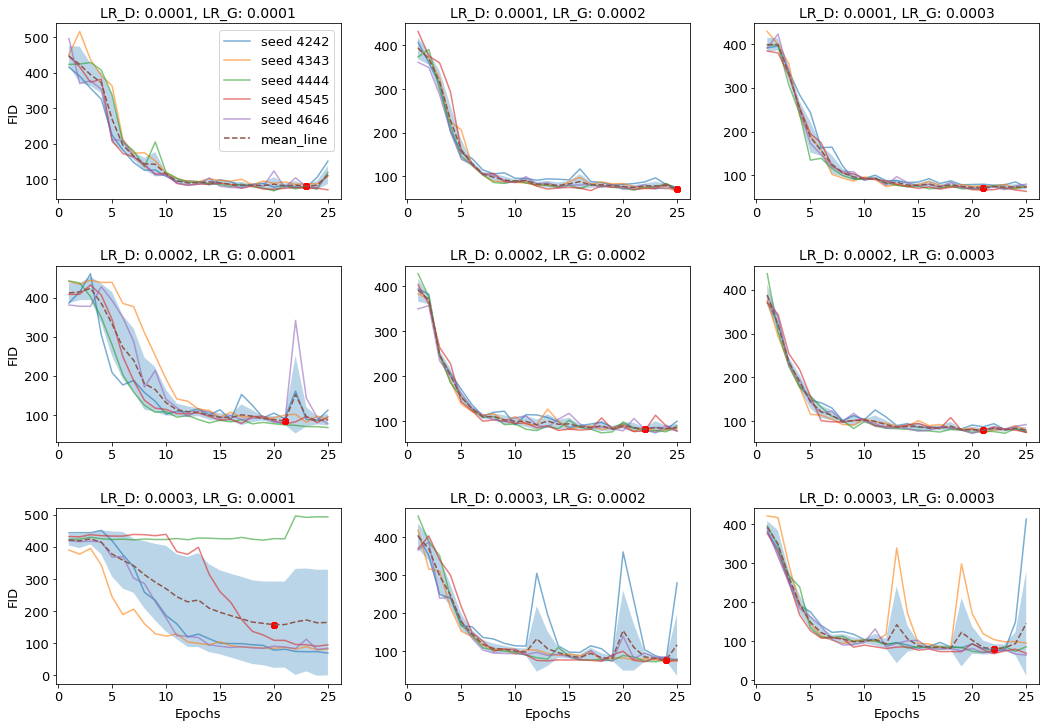

In [47]:
# create plot for 2nd group of hyperparams for GAN, bs=128
import matplotlib
matplotlib.rcParams.update({'font.size': 13})

lr_list = [(0.0001, 0.0001), (0.0001, 0.0002), (0.0001, 0.0003),
          (0.0002, 0.0001), (0.0002, 0.0002), (0.0002, 0.0003),
          (0.0003, 0.0001), (0.0003, 0.0002), (0.0003, 0.0003)]
b_sizes = [128]

fig, ax = plt.subplots(figsize=(15,11), nrows=3, ncols=3)
ax = ax.flatten()
dat_gan = create_dict(find_logs('new_hyps')[1], 128)


for b_size in b_sizes:
    for e,lr in enumerate(lr_list):
        data, means, stds = separate(dat_gan, lr[0], lr[1], b_size)
        p = create_line_plot(data, means, stds, ax=ax[e])
        eps = [i for i in range(1, len(data[0]['FIDs'])+1)]

ax[0].legend(fontsize='medium')

#fig.suptitle(f"{dat_gan[0]['gan_type']} trained for {len(eps)} epochs with batch size {b_sizes[0]}", fontsize = 17)
fig.tight_layout(pad=2.5)
fig.subplots_adjust(top=0.90)
plt.setp(ax[[6,7,8]], xlabel='Epochs')
plt.setp(ax[[0,3,6]], ylabel='FID')

plt.savefig(f'plots/gan_hyperset_{b_sizes[0]}.jpg', bbox_inches='tight')

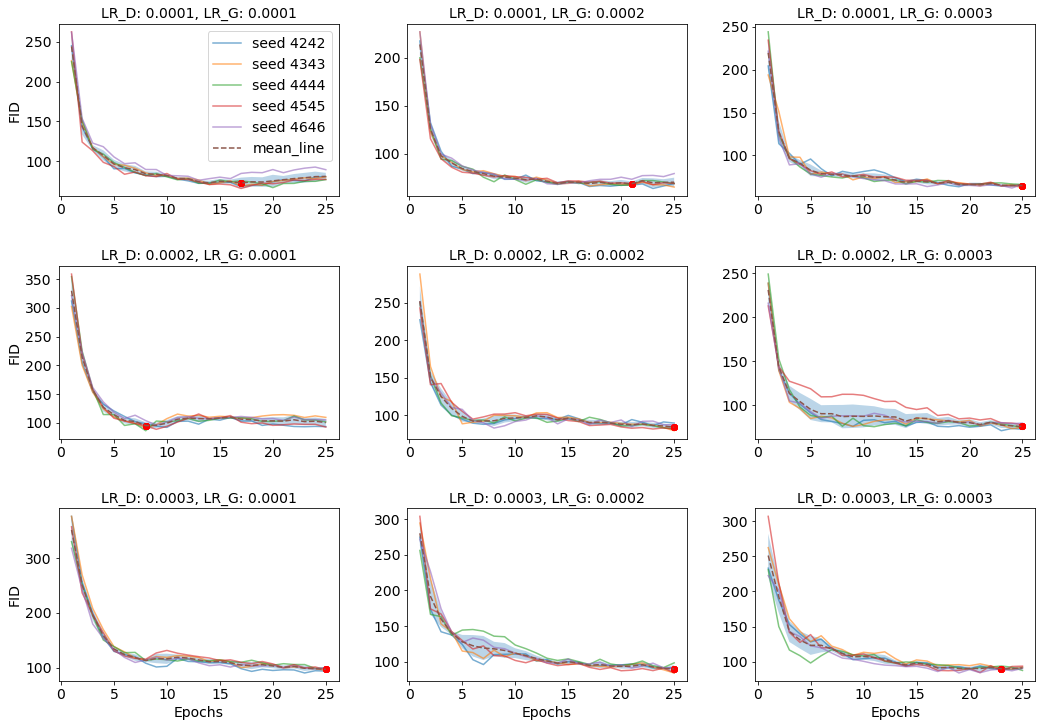

In [48]:
# create plot for 2nd group of hyperparams for WGAN, bs=64
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

lr_list = [ (0.0001, 0.0001),(0.0001, 0.0002), (0.0001, 0.0003),
          (0.0002, 0.0001), (0.0002, 0.0002), (0.0002, 0.0003),
          (0.0003, 0.0001), (0.0003, 0.0002), (0.0003, 0.0003)]
b_sizes = [64]

fig, ax = plt.subplots(figsize=(15,11), nrows=3, ncols=3)
ax = ax.flatten()
dat_gan = create_dict(find_logs('new_hyps')[0], 128)

# for i in dat_gan:
#     print(f" gan_type: {i['gan_type']} LR_D: {i['LR_D']} LR_G: {i['LR_G']} SEED: {i['SEED']} b_size: {i['BATCH_SIZE']} FID_shape_correctness: {1 if len(i['FIDs']) == 25 else 0}")


for b_size in b_sizes:
    for e,lr in enumerate(lr_list):
        data, means, stds = separate(dat_gan, lr[0], lr[1], b_size)
        p = create_line_plot(data, means, stds, ax=ax[e])
        eps = [i for i in range(1, len(data[0]['FIDs'])+1)]

ax[0].legend(fontsize='medium')

#fig.suptitle(f"{dat_gan[0]['gan_type']} trained for {len(eps)} epochs with batch size {b_sizes[0]}", fontsize = 17)
fig.tight_layout(pad=2.5)
fig.subplots_adjust(top=0.90)
plt.setp(ax[[6,7,8]], xlabel='Epochs')
plt.setp(ax[[0,3,6]], ylabel='FID')
#plt.xticks(fontsize=16)

plt.savefig(f'plots/wgan_hyperset_{b_sizes[0]}.jpg', bbox_inches='tight')

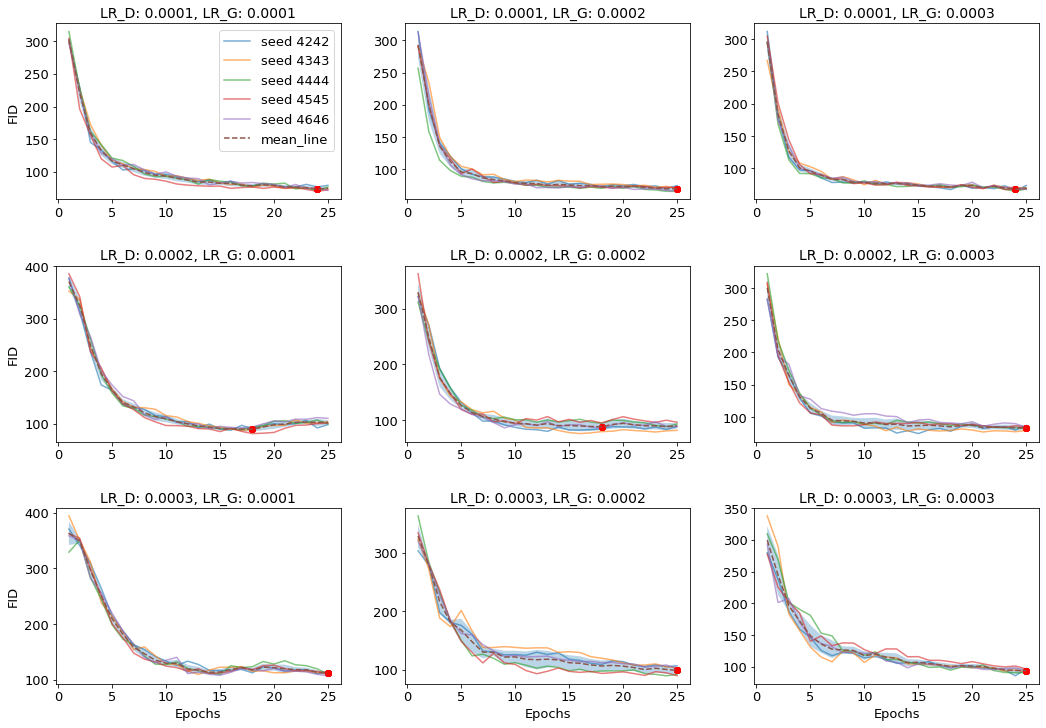

In [49]:
# create plot for 2nd group of hyperparams for WGAN, bs=128
import matplotlib
matplotlib.rcParams.update({'font.size': 13})

lr_list = [ (0.0001, 0.0001), (0.0001, 0.0002), (0.0001, 0.0003),
          (0.0002, 0.0001), (0.0002, 0.0002), (0.0002, 0.0003),
          (0.0003, 0.0001), (0.0003, 0.0002), (0.0003, 0.0003)]
b_sizes = [128]

fig, ax = plt.subplots(figsize=(15,11), nrows=3, ncols=3)
ax = ax.flatten()
dat_gan = create_dict(find_logs('new_hyps')[0], 128)

# for i in dat_gan:
#     print(f" gan_type: {i['gan_type']} LR_D: {i['LR_D']} LR_G: {i['LR_G']} SEED: {i['SEED']} b_size: {i['BATCH_SIZE']} FID_shape_correctness: {1 if len(i['FIDs']) == 25 else 0}")


for b_size in b_sizes:
    for e,lr in enumerate(lr_list):
        data, means, stds = separate(dat_gan, lr[0], lr[1], b_size)
        p = create_line_plot(data, means, stds, ax=ax[e])
        eps = [i for i in range(1, len(data[0]['FIDs'])+1)]

ax[0].legend(fontsize='medium')
        
#fig.suptitle(f"{dat_gan[0]['gan_type']} trained for {len(eps)} epochs with batch size {b_sizes[0]}", fontsize = 17)
fig.tight_layout(pad=2.5)
fig.subplots_adjust(top=0.90)
plt.setp(ax[[6,7,8]], xlabel='Epochs')
plt.setp(ax[[0,3,6]], ylabel='FID')

plt.savefig(f'plots/wgan_hyperset_{b_sizes[0]}.jpg', bbox_inches='tight')

In [68]:
import pandas as pd

lr_list = [(0.0001, 0.0001), (0.0001, 0.0002), (0.0001, 0.0003),
          (0.0002, 0.0001), (0.0002, 0.0002), (0.0002, 0.0003),
          (0.0003, 0.0001), (0.0003, 0.0002), (0.0003, 0.0003)]
b_sizes = [128]

res = pd.DataFrame()
data = create_dict(find_logs('new_hyps')[1], 128)
fids_gan_128 = []
fids_gan_128_best = []

for b_size in b_sizes:
    for e,lr in enumerate(lr_list):
        last_fids = []
        best_fids = []
        dat, means, stds = separate(data, lr[0], lr[1], b_size)
        last_fid, lr_d, lr_g, bsize, gan_type = means[-1], dat[0]['LR_D'], dat[0]['LR_G'], dat[0]['BATCH_SIZE'], dat[0]['gan_type']
        print(means)
        print(np.argmin(means)+1)
        #fids_gan_128_best.append((round(means[np.argmin(means)], 2), round(stds[np.argmin(means)], 2)))
        for i in dat:
            last_fids.append((i['FIDs'][-1]))
            best_fids.append(i['FIDs'][np.argmin(means)])
        print(last_fids)
        res = res.append({'LR_D and LR_G' : (lr_d, lr_g), 'Mean FID from last epoch across all runs' : f'{round(last_fid, 2)} \u00B1 {round(stds[-1], 2)}', 'Batch Size' : str(bsize), 'GAN Type': gan_type, 'Best FID from last epoch over all runs': min(last_fids)}, ignore_index=True)
        fids_gan_128_best.append(best_fids)
        fids_gan_128.append(last_fids)

res = res[ [ col for col in res.columns if col != 'Best FID from last epoch over all runs' ] + ['Best FID from last epoch over all runs'] ]
print(fids_gan_128)
print(fids_gan_128_best)
res.to_excel('results_gan_128.xlsx')
res

[446.33747515 422.94198641 394.38856791 371.74716065 268.88462647
 196.20626321 165.50135703 143.38921933 142.29114985 114.58223237
  95.4642981   89.72624186  90.3064574   92.93530551  90.06566851
  85.93134409  83.64294454  83.35606022  82.42276351  86.09683357
  81.79323364  83.75794247  79.99892816  83.3719993  112.27863872]
23
[151.081952238896, 108.5228891099446, 119.66432397249605, 70.40482496413256, 111.71920333571165]
[393.61215066 369.32939897 316.24022779 228.65955123 160.69381186
 129.35464167 105.80354577  97.5618503   91.38739075  88.69121069
  90.60066136  82.03068326  81.69054401  78.67745685  82.67071502
  87.75727644  79.90008939  80.4784906   78.71688421  76.61379707
  74.43450321  77.63433012  77.92518182  78.24820905  70.40939587]
25
[74.54859753353958, 65.99666003890854, 70.54871695953415, 65.33163962754423, 75.62136518747252]
[398.36873203 398.81900131 332.28149214 252.95053933 187.39835281
 156.44382015 125.12762223 105.79003234  96.75059995  92.3628807
  93.940

,Batch Size,GAN Type,LR_D and LR_G,Mean FID from last epoch across all runs,Best FID from last epoch over all runs
0,128,GAN,"(0.0001, 0.0001)",112.28 ± 25.8,70.404825
1,128,GAN,"(0.0001, 0.0002)",70.41 ± 4.23,65.331640
2,128,GAN,"(0.0001, 0.0003)",73.25 ± 5.36,63.647556
3,128,GAN,"(0.0002, 0.0001)",88.39 ± 15.19,68.098294
4,128,GAN,"(0.0002, 0.0002)",86.4 ± 8.17,77.838542
5,128,GAN,"(0.0002, 0.0003)",79.36 ± 6.64,74.061583
6,128,GAN,"(0.0003, 0.0001)",164.08 ± 165.09,68.297737
7,128,GAN,"(0.0003, 0.0002)",116.23 ± 81.83,72.601188
8,128,GAN,"(0.0003, 0.0003)",145.51 ± 134.01,64.622602


In [71]:
lr_list = [(0.0001, 0.0001), (0.0001, 0.0002), (0.0001, 0.0003),
          (0.0002, 0.0001), (0.0002, 0.0002), (0.0002, 0.0003),
          (0.0003, 0.0001), (0.0003, 0.0002), (0.0003, 0.0003)]
b_sizes = [128]


res = pd.DataFrame()
data = create_dict(find_logs('new_hyps')[0], 128)
fids_wgan_128 = []
fids_wgan_128_best = []

for b_size in b_sizes:
    for e,lr in enumerate(lr_list):
        last_fids = []
        best_fids = []
        dat, means, stds = separate(data, lr[0], lr[1], b_size)
        last_fid, lr_d, lr_g, bsize, gan_type = means[-1], dat[0]['LR_D'], dat[0]['LR_G'], dat[0]['BATCH_SIZE'], dat[0]['gan_type']
        print(means)
        print(np.argmin(means)+1)
        #fids_gan_128_best.append((round(means[np.argmin(means)], 2), round(stds[np.argmin(means)], 2)))
        for i in dat:
            last_fids.append((i['FIDs'][-1]))
            best_fids.append(i['FIDs'][np.argmin(means)])
        print(last_fids)
        res = res.append({'LR_D and LR_G' : (lr_d, lr_g), 'Mean FID from last epoch across all runs' : f'{round(last_fid, 2)} \u00B1 {round(stds[-1], 2)}', 'Batch Size' : str(bsize), 'GAN Type': gan_type, 'Best FID from last epoch over all runs': min(last_fids)}, ignore_index=True)
        fids_wgan_128_best.append(best_fids)
        fids_wgan_128.append(last_fids)

res = res[ [ col for col in res.columns if col != 'Best FID from last epoch over all runs' ] + ['Best FID from last epoch over all runs'] ]

res.to_excel('results_wgan_128.xlsx')
res

[303.13970703 220.38884081 159.14553936 132.79993363 116.30915918
 110.45114472 104.82937045  98.90214512  94.82844838  93.546683
  90.12433625  87.38231503  84.09874909  84.33790841  82.36218859
  82.08431899  79.60553434  78.62320841  79.95335904  79.15052614
  76.94696266  76.5192291   75.87660282  73.30652722  74.82564152]
24
[79.27048271253989, 74.3586174965281, 76.5020546923339, 72.4053869435786, 71.59166573890343]
[293.07405233 200.11324071 136.23443853 112.29102528  96.0462765
  93.45402053  86.69487844  84.34128455  82.47431051  79.40819739
  78.3371505   78.03731185  75.41184247  76.84019488  75.75766753
  74.87866355  74.72578631  73.44541233  73.8699228   73.33977582
  73.58288257  72.18867726  71.14070929  69.86624584  69.81385483]
25
[75.01746659787642, 70.18638068841699, 65.94773886271372, 71.91442593866543, 66.00326208413253]
[295.1203387  183.50289446 126.98697369 100.66831611  95.63220068
  89.1255779   82.7273985   82.5172706   78.61879536  77.94913266
  77.09855998 

,Batch Size,GAN Type,LR_D and LR_G,Mean FID from last epoch across all runs,Best FID from last epoch over all runs
0,128,WGAN,"(0.0001, 0.0001)",74.83 ± 2.8,71.591666
1,128,WGAN,"(0.0001, 0.0002)",69.81 ± 3.5,65.947739
2,128,WGAN,"(0.0001, 0.0003)",69.37 ± 2.14,67.196676
3,128,WGAN,"(0.0002, 0.0001)",102.9 ± 4.16,98.506656
4,128,WGAN,"(0.0002, 0.0002)",89.8 ± 4.87,81.876679
5,128,WGAN,"(0.0002, 0.0003)",83.29 ± 2.68,79.135278
6,128,WGAN,"(0.0003, 0.0001)",111.25 ± 2.57,107.022069
7,128,WGAN,"(0.0003, 0.0002)",98.66 ± 6.67,89.788558
8,128,WGAN,"(0.0003, 0.0003)",93.77 ± 2.6,90.649946


In [72]:
lr_list = [(0.0001, 0.0001), (0.0001, 0.0002), (0.0001, 0.0003),
          (0.0002, 0.0001), (0.0002, 0.0002), (0.0002, 0.0003),
          (0.0003, 0.0001), (0.0003, 0.0002), (0.0003, 0.0003)]
b_sizes = [64]

# [(0.0001, 5e-05), (0.0002, 5e-05), (0.0004, 0.0001), (0.0004, 0.0002)]
res = pd.DataFrame()
data = create_dict(find_logs('new_hyps')[0], 128)
fids_wgan_64 = []
fids_wgan_64_best = []

for b_size in b_sizes:
    for e,lr in enumerate(lr_list):
        last_fids = []
        best_fids = []
        dat, means, stds = separate(data, lr[0], lr[1], b_size)
        last_fid, lr_d, lr_g, bsize, gan_type = means[-1], dat[0]['LR_D'], dat[0]['LR_G'], dat[0]['BATCH_SIZE'], dat[0]['gan_type']
        print(means)
        print(np.argmin(means)+1)
        #fids_gan_128_best.append((round(means[np.argmin(means)], 2), round(stds[np.argmin(means)], 2)))
        for i in dat:
            last_fids.append((i['FIDs'][-1]))
            best_fids.append(i['FIDs'][np.argmin(means)])
        print(last_fids)
        res = res.append({'LR_D and LR_G' : (lr_d, lr_g), 'Mean FID from last epoch across all runs' : f'{round(last_fid, 2)} \u00B1 {round(stds[-1], 2)}', 'Batch Size' : str(bsize), 'GAN Type': gan_type, 'Best FID from last epoch over all runs': min(last_fids)}, ignore_index=True)
        fids_wgan_64_best.append(best_fids)
        fids_wgan_64.append(last_fids)

res = res[ [ col for col in res.columns if col != 'Best FID from last epoch over all runs' ] + ['Best FID from last epoch over all runs'] ]

res.to_excel('results_wgan_64.xlsx')
res
fids_wgan_64_best

[244.11640274 144.03557712 116.70264573 107.16710976  96.51437078
  91.55860575  89.21311654  84.05693705  83.3030273   81.81985268
  78.16733597  77.83318207  73.97815427  72.67691362  74.59086651
  74.15060768  72.37155638  73.89185149  73.6335585   75.13844323
  76.51009613  77.99888313  78.96970937  80.43212135  80.69420933]
17
[80.40796967441045, 80.23748741111746, 76.69083711601948, 76.96718732804749, 89.16756512704194]
[213.76226693 125.29678967  97.70097249  90.23547181  84.35545725
  81.23971965  79.07990274  76.40770143  75.47817827  74.32039977
  72.87953696  73.40771417  71.08250958  68.73270372  70.18234549
  70.09005957  68.73334061  69.83210974  68.85445314  69.40003055
  68.60404752  71.65040617  69.54756729  69.86993411  70.09313204]
21
[68.78581586806092, 65.03365145765792, 68.77424089295812, 68.72699435726594, 79.14495764867729]
[219.62080665 127.60610002  96.66972428  90.86421217  82.72488496
  78.86945122  77.84351144  77.4016627   75.75575429  76.22786942
  74.516

[[68.44035762785415,
  68.22215727709226,
  75.19906147372996,
  65.55035337296732,
  84.4458521348694],
 [67.07638542107105,
  66.82564988337634,
  67.7836244178664,
  68.16042191197175,
  73.17415596195599],
 [64.87892688196132,
  61.51706926082238,
  66.2480873524488,
  65.68696993395389,
  66.1716283470227],
 [98.22701313832746,
  91.72273678373534,
  86.15912525831382,
  94.81317345291939,
  103.72988944900212],
 [89.41123973968752,
  79.17506268491732,
  82.15748921343487,
  81.5070443913906,
  86.98800383435969],
 [72.72281945872169,
  74.97724529045985,
  74.45281601682487,
  78.12493210131572,
  79.72317315315303],
 [93.90123531669155,
  94.98159102063465,
  99.39818481640515,
  96.14968646803823,
  100.46226590262961],
 [91.85697006741069,
  84.46070224248206,
  98.58538371596217,
  84.54107326228484,
  91.56430174218949],
 [89.2169767655655,
  90.57061500121242,
  93.70766096749793,
  86.06666069813252,
  89.40955718151065]]

In [77]:
import pandas as pd

lr_list = [(0.0001, 0.0001), (0.0001, 0.0002), (0.0001, 0.0003),
          (0.0002, 0.0001), (0.0002, 0.0002), (0.0002, 0.0003),
          (0.0003, 0.0001), (0.0003, 0.0002), (0.0003, 0.0003)]
b_sizes = [64]

res = pd.DataFrame()
data = create_dict(find_logs('new_hyps')[1], 128)
fids_gan_64 = []
fids_gan_64_best = []

for b_size in b_sizes:
    for e,lr in enumerate(lr_list):
        last_fids = []
        best_fids = []
        dat, means, stds = separate(data, lr[0], lr[1], b_size)
        last_fid, lr_d, lr_g, bsize, gan_type = means[-1], dat[0]['LR_D'], dat[0]['LR_G'], dat[0]['BATCH_SIZE'], dat[0]['gan_type']
        print(means)
        print(np.argmin(means)+1)
        #fids_gan_128_best.append((round(means[np.argmin(means)], 2), round(stds[np.argmin(means)], 2)))
        for i in dat:
            last_fids.append((i['FIDs'][-1]))
            best_fids.append(i['FIDs'][np.argmin(means)])
        print(last_fids)
        res = res.append({'LR_D and LR_G' : (lr_d, lr_g), 'Mean FID from last epoch across all runs' : f'{round(last_fid, 2)} \u00B1 {round(stds[-1], 2)}', 'Batch Size' : str(bsize), 'GAN Type': gan_type, 'Best FID from last epoch over all runs': min(last_fids)}, ignore_index=True)
        fids_gan_64_best.append(best_fids)
        fids_gan_64.append(last_fids)
        
res = res[ [ col for col in res.columns if col != 'Best FID from last epoch over all runs' ] + ['Best FID from last epoch over all runs'] ]

res.to_excel('results_gan_64.xlsx')
res

[387.18880964 383.49801989 181.47667455 146.53282741 116.45268778
  99.15485048  89.34257603  92.8732433   85.57172454  90.33060633
  86.5670096   84.17415091  88.7101854   80.50592807  84.94479991
  81.81354041  84.60643772  80.74023693  83.58999106  84.08330624
  79.55687498  83.19131263  92.22442959 145.2001233  136.71631203]
21
[90.79945604267104, 81.24870335924635, 328.22920988582024, 107.01925289061728, 76.28493797779049]
[403.13364095 206.57497337 143.33667398 108.09462748  98.76927847
  87.03309409  87.13675855  89.68077953  82.8660435   82.57865675
  79.18019674  83.0659179   84.09011393  79.85443997  76.70999214
  83.54143204  78.86619773  75.33592564  83.21219529  80.9383803
  73.99710087  75.11539341  78.83307583  73.35690459 112.16363872]
24
[256.0413134444535, 75.66310131998642, 88.768251706829, 67.11242636517977, 73.23310075039052]
[381.23053767 262.33037659 168.25909114 111.48665627 104.28931373
  89.31125338  85.96394741  79.3227158   79.0031758   77.99390881
  78.6914

,Batch Size,GAN Type,LR_D and LR_G,Mean FID from last epoch across all runs,Best FID from last epoch over all runs
0,64,GAN,"(0.0001, 0.0001)",136.72 ± 96.33,76.284938
1,64,GAN,"(0.0001, 0.0002)",112.16 ± 72.29,67.112426
2,64,GAN,"(0.0001, 0.0003)",140.88 ± 130.18,67.007124
3,64,GAN,"(0.0002, 0.0001)",173.56 ± 148.69,76.906312
4,64,GAN,"(0.0002, 0.0002)",110.46 ± 68.59,71.637810
5,64,GAN,"(0.0002, 0.0003)",114.17 ± 69.09,68.348994
6,64,GAN,"(0.0003, 0.0001)",159.61 ± 178.9,68.135598
7,64,GAN,"(0.0003, 0.0002)",128.33 ± 120.16,63.995454
8,64,GAN,"(0.0003, 0.0003)",136.63 ± 117.44,64.794847


In [25]:
import scipy

mann_w = scipy.stats.mannwhitneyu

In [26]:
df_sign = pd.DataFrame()
df_sign_128 = pd.DataFrame()
for lrs,i,k,j,l in zip(lr_list, fids_gan_64, fids_wgan_64, fids_gan_128, fids_wgan_128):
    df_sign = df_sign.append({'Learning rates': (lrs[0], lrs[1]), 'Last DCGAN_64': f"{round(np.mean(i), 2)} \u00B1 {round(np.std(i), 2)}", 'Last WGAN_64': f"{round(np.mean(k), 2)} \u00B1 {round(np.std(k), 2)}", 'P-value': round(mann_w(i,k)[1], 4) }, ignore_index=True)
    df_sign_128 = df_sign_128.append({'Learning rates': (lrs[0], lrs[1]), 'Last DCGAN_128': f"{round(np.mean(j), 2)} \u00B1 {round(np.std(j), 2)}", 'Last WGAN_128': f"{round(np.mean(l), 2)} \u00B1 {round(np.std(l), 2)}", 'P-value': round(mann_w(j,l)[1], 4) }, ignore_index=True)
df_sign

,Last DCGAN_64,Last WGAN_64,Learning rates,P-value
0,257.15 ± 137.32,286.6 ± 73.57,"(0.01, 0.01)",0.5000
1,209.47 ± 161.43,330.37 ± 53.23,"(0.01, 0.001)",0.3381
2,403.57 ± 21.39,376.75 ± 6.24,"(0.01, 0.0001)",0.0718
3,419.29 ± 11.16,452.0 ± 40.07,"(0.01, 1e-05)",0.0718
4,452.62 ± 43.06,269.89 ± 10.02,"(0.001, 0.01)",0.0061
5,349.52 ± 140.9,238.58 ± 14.14,"(0.001, 0.001)",0.0718
6,143.15 ± 132.45,260.29 ± 24.03,"(0.001, 0.0001)",0.0718
7,452.73 ± 52.19,336.65 ± 11.0,"(0.001, 1e-05)",0.0061
8,336.47 ± 99.32,103.35 ± 15.12,"(0.0001, 0.01)",0.0061
9,60.61 ± 0.86,68.12 ± 7.28,"(0.0001, 0.001)",0.0061


In [27]:
df_sign_128
df_sign.to_excel('significance_last_64.xlsx'), df_sign_128.to_excel('significance_last_128.xlsx')

(None, None)

In [28]:
df_sign = pd.DataFrame()
df_sign_128 = pd.DataFrame()
for lrs,i,k,j,l in zip(lr_list, fids_gan_64_best, fids_wgan_64_best, fids_gan_128_best, fids_wgan_128_best):
    df_sign = df_sign.append({'Learning rates': (lrs[0], lrs[1]), 'Best DCGAN_64': f"{round(np.mean(i), 2)} \u00B1 {round(np.std(i), 2)}", 'Best WGAN_64': f"{round(np.mean(k), 2)} \u00B1 {round(np.std(k), 2)}", 'P-value': round(mann_w(i,k)[1], 4) }, ignore_index=True)
    df_sign_128 = df_sign_128.append({'Learning rates': (lrs[0], lrs[1]), 'Best DCGAN_128': f"{round(np.mean(j), 2)} \u00B1 {round(np.std(j), 2)}", 'Best WGAN_128': f"{round(np.mean(l), 2)} \u00B1 {round(np.std(l), 2)}", 'P-value': round(mann_w(j,l)[1], 4) }, ignore_index=True)
df_sign

,Best DCGAN_64,Best WGAN_64,Learning rates,P-value
0,257.15 ± 137.32,273.16 ± 75.29,"(0.01, 0.01)",0.5000
1,209.47 ± 161.43,300.08 ± 28.22,"(0.01, 0.001)",0.3381
2,403.57 ± 21.39,362.27 ± 19.35,"(0.01, 0.0001)",0.0301
3,419.29 ± 11.16,403.3 ± 8.68,"(0.01, 1e-05)",0.0184
4,289.24 ± 96.27,234.62 ± 15.89,"(0.001, 0.01)",0.1481
5,259.35 ± 164.95,206.03 ± 11.81,"(0.001, 0.001)",0.3381
6,138.24 ± 136.99,255.21 ± 26.35,"(0.001, 0.0001)",0.0718
7,395.14 ± 34.86,336.65 ± 11.0,"(0.001, 1e-05)",0.0108
8,78.46 ± 4.17,98.6 ± 16.32,"(0.0001, 0.01)",0.0108
9,60.61 ± 0.86,68.12 ± 7.28,"(0.0001, 0.001)",0.0061


In [30]:
df_sign_128
df_sign.to_excel('significance_best_64.xlsx'), df_sign_128.to_excel('significance_best_128.xlsx')

(None, None)